# Barycenter-based worm straightening (easy example)

In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import downscale_local_mean
from scipy.ndimage import geometric_transform
from scipy.stats import multivariate_normal
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from otimage.potmods import barycenter_sinkhorn
from otimage.utils import pixel_dist_3d

### Create two test frames

In [3]:
img_shape = (50, 25, 5)

# Grid for evaluating densities on
xg, yg, zg = np.mgrid[0:img_shape[0], 0:img_shape[1], 0:img_shape[2]]
grid = np.stack((xg, yg, zg), axis=-1)

# Means of Gaussian bumps in frames
mu_1 = np.array([20, 10, 3])
mu_2 = np.array([40, 10, 3])

# Covariance is same for both frames
cov = 5 * np.eye(3)

frame_1 = multivariate_normal.pdf(grid, mu_1, cov).reshape(img_shape)
frame_2 = multivariate_normal.pdf(grid, mu_2, cov).reshape(img_shape)

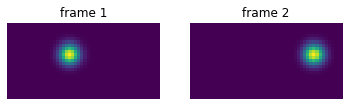

In [4]:
plt.subplot(121)
plt.imshow(np.max(frame_1, 2).T);
plt.title('frame 1')
plt.axis('off')

plt.subplot(122)
plt.imshow(np.max(frame_2, 2).T);
plt.title('frame 2')
plt.axis('off');

### Compute barycenter

In [5]:
# Normalized pixel distance matrix 
M_nn = pixel_dist_3d(*img_shape)
M = M_nn / np.median(M_nn)

# Entropic regularization parameter
reg = 1e-3

# Compute barycenter and transport plans
A = np.hstack([frame_1.reshape(-1, 1), frame_2.reshape(-1, 1)])
bc_vec, u, v, K = barycenter_sinkhorn(A, M, reg)
bc_img = bc_vec.reshape(img_shape)

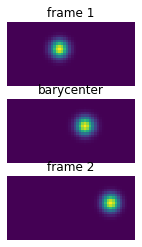

In [6]:
plt.subplot(311)
plt.imshow(np.max(frame_1, 2).T);
plt.title('frame 1')
plt.axis('off')

plt.subplot(312)
plt.imshow(np.max(bc_img, 2).T);
plt.title('barycenter')
plt.axis('off')

plt.subplot(313)
plt.imshow(np.max(frame_2, 2).T);
plt.title('frame 2')
plt.axis('off');

### Compute transport plan

In [7]:
# Frame
frame_idx = 0
frame = frame_1

# Reconstruct transport plan from u, v, and K
u1 = u[:, frame_idx]
v1 = v[:, frame_idx]
P = np.diag(u1) @ K @ np.diag(v1)

# Compute marginals of transport plan
m1_vec = np.sum(P, axis=0)
m2_vec = np.sum(P, axis=1)
m1_img = m1_vec.reshape(img_shape)
m2_img = m2_vec.reshape(img_shape)

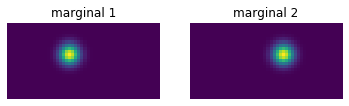

In [8]:
plt.subplot(121)
plt.imshow(np.max(m1_img, 2).T)
plt.axis('off')
plt.title('marginal 1')

plt.subplot(122)
plt.imshow(np.max(m2_img, 2).T)
plt.axis('off')
plt.title('marginal 2');

### Compute deterministic map from barycenter to original frame

In [9]:
# Compute pushforward from barycenter to original worm
T = P / bc_vec.reshape(-1, 1)

# Get all pixel coordinates
n_grid_pts = img_shape[0] * img_shape[1] * img_shape[2]
grid_vals = grid.reshape(n_grid_pts, 3)

# Multiply grid points by pushforward matrix to get 'transformed' points
t_vals = T @ grid_vals

# Fit cubic polynomial regression model to points and transformed points
model = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('linear', LinearRegression(fit_intercept=True))
])
model.fit(grid_vals, t_vals)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linear',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

### Use deterministic map to transform original frame to barycenter

In [10]:
def inv_map(coords):
    in_arr = np.array(coords).reshape(1, -1)
    out_arr = model.predict(in_arr)
    return tuple(out_arr.flatten())

t_frame = geometric_transform(frame, inv_map)

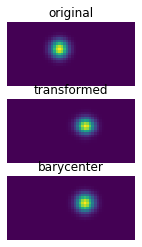

In [11]:
plt.subplot(311)
plt.imshow(np.max(frame, 2).T)
plt.axis('off')
plt.title('original')

plt.subplot(312)
plt.imshow(np.max(t_frame, 2).T)
plt.axis('off')
plt.title('transformed')

plt.subplot(313)
plt.imshow(np.max(bc_img, 2).T)
plt.axis('off')
plt.title('barycenter');

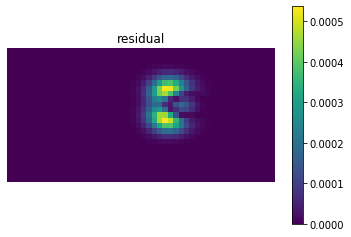

In [12]:
plt.imshow(np.abs(np.max(bc_img - t_frame, 2)).T)
plt.colorbar()
plt.axis('off')
plt.title('residual');